In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
cd C:\Users\诚明\Desktop\MachineLearning\machine-learning-ex5\ex5

C:\Users\诚明\Desktop\MachineLearning\machine-learning-ex5\ex5


In [3]:
mat=scipy.io.loadmat('ex5data1.mat')

In [159]:
X,y=mat['X'],mat['y']
Xtest,ytest=mat['Xtest'],mat['ytest']
Xval,yval=mat['Xval'],mat['yval']

In [160]:
X=np.insert(X,0,1,axis=1)
Xval=np.insert(Xval,0,1,axis=1)
Xtest=np.insert(Xtest,0,1,axis=1)

# 1. Regularized Linear Regression

## 1.1 Data Visualization

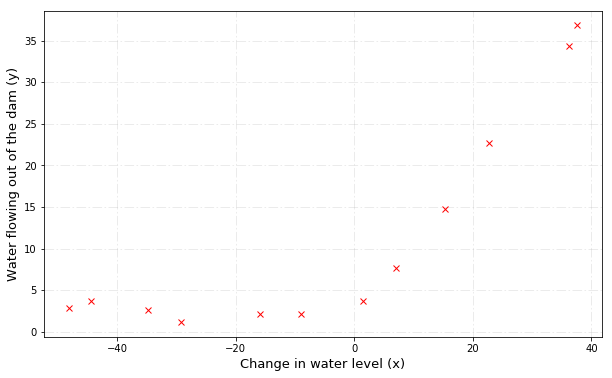

In [7]:
def plotData():
    plt.figure(figsize=(10,6))
    plt.plot(X[:,-1],y,'rx')
    plt.xlabel('Change in water level (x)',fontsize=13)
    plt.ylabel('Water flowing out of the dam (y)',fontsize=13)
    plt.grid(linestyle='-.',alpha=0.3)

plotData()

## 1.2 Cost function, Gradient and Theta Optimization (similar to gradient descent)

In [8]:
def costfunc(theta,x,y,lam=0):
    m=x.shape[0]
    theta=theta.reshape((theta.shape[0],1))   # Note that to be applied to fmin_cg, input theta will be in flat form.
    temp=(x.dot(theta)-y).T.dot(x.dot(theta)-y)
    cost=temp/2/m
    rem=lam/2/m*theta[1:].T.dot(theta[1:])
    return float(cost)+float(rem)

In [9]:
initial_theta=np.ones((2,1))
costfunc(initial_theta,X,y,lam=1)

303.9931922202643

In [10]:
def gradient(theta,x,y,lam=0):
    m=x.shape[0]
    theta=theta.reshape((theta.shape[0],1))       # Note that to be applied to fmin_cg, input theta should be in flat form.
    grad=x.T.dot(x.dot(theta)-y)/m
    grad[1:]+=lam/m*theta[1:]
    return grad

def gradientflatten(theta,x,y,lam=0):        # This is for the minimization routine that wants everything flattened
    return gradient(theta,x,y,lam).flatten()

In [11]:
gradient(initial_theta,X,y,lam=1)

array([[ -15.30301567],
       [ 598.25074417]])

In [12]:
def optimization(theta,x,y,lam=0,print_output=True):
    result=scipy.optimize.fmin_cg(costfunc,x0=theta,fprime=gradientflatten,\
                                  args=(x,y,lam),disp=print_output,epsilon=1.49e-12,maxiter=1000)      # control whether to display output
    return result

In [13]:
def optimize1(theta,x,y,lam=0):
    result = scipy.optimize.minimize(costfunc, theta, args=(x,y,lam),  method='BFGS', options={"maxiter":500, "disp":False} )
    return result

In [14]:
result=optimization(initial_theta,X,y)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


In [15]:
fit_theta=result.reshape((2,1))

In [16]:
fit_theta

array([[ 13.08790734],
       [  0.36777925]])

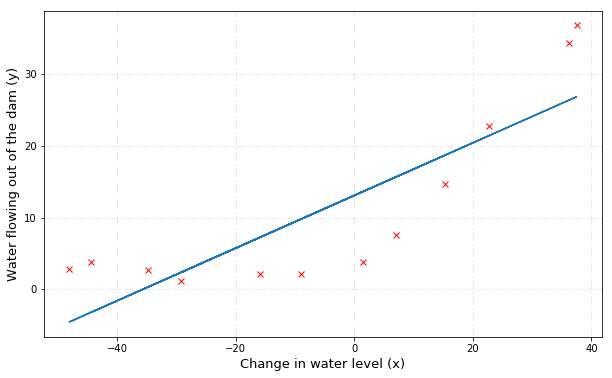

In [17]:
plotData()
plt.plot(X[:,1],np.dot(X,fit_theta))

# 2. Bias and Variance

## 2.1 Learning Curve for Linear Regression

In [161]:
def plotLearningCurve():
    yshape,error_train,error_val=[],[],[]
    theta=np.array([[1],[1]])
    for i in range(1,13):
        xx=X[:i,:]
        yy=y[:i]
        yshape.append(yy.shape[0])
        fitted_theta=optimize1(theta,xx,yy).x.reshape((2,1))        # can't figure out why optimization function fails 
        error_train.append(costfunc(fitted_theta,xx,yy))
        error_val.append(costfunc(fitted_theta,Xval,yval))
    plt.figure(figsize=(10,7))
    plt.plot(yshape,error_train,label='Train')
    plt.plot(yshape,error_val,label='Validation')
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(linestyle='-.',alpha=0.3)
    plt.legend()

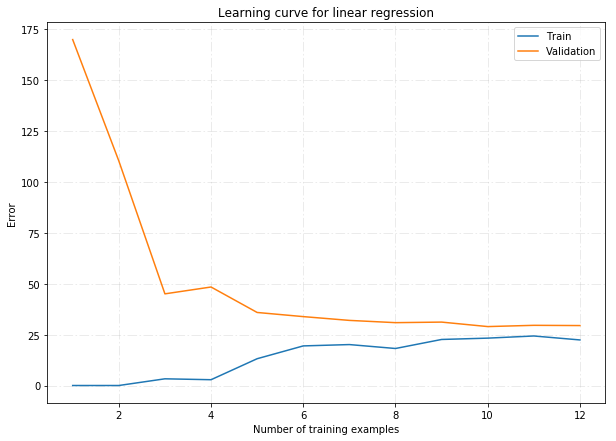

In [162]:
plotLearningCurve()           # This implies a high bias issue since the Jtrain and Jval are both high and similar to each other.
                              # The increase of size of training examples won't help.

## 2.2 Polynomial Regression

In [20]:
X,y=mat['X'],mat['y']
Xtest,ytest=mat['Xtest'],mat['ytest']
Xval,yval=mat['Xval'],mat['yval']

In [21]:
def polyFeatures(x,p):
    X_poly=x
    for i in range(2,p+1):
        X_poly=np.c_[X_poly,x**i]
    return X_poly

In [48]:
def featureNormalize(x):
    return (x-np.mean(x,axis=0))/np.std(x,axis=0),np.mean(x,axis=0),np.std(x,axis=0)        # Three elements in the output

In [41]:
X_poly,mu,sigma=featureNormalize(polyFeatures(X,6))
X_poly=np.insert(X_poly,0,1,axis=1)

In [42]:
start_theta=np.ones((7,1))
fitted_theta=optimize1(start_theta,X_poly,y).x.reshape(7,1)

In [43]:
fitted_theta

array([[ 11.21758956],
       [ 11.37087972],
       [ 13.43396898],
       [ 10.74229214],
       [ -4.38775962],
       [-11.92157675],
       [ -5.12169513]])

In [49]:
def plotFit(fit_theta,means,stds):
    xx=np.linspace(-55,55,50).reshape((50,1))
    xx_poly=polyFeatures(xx,6)
    xx_poly=np.insert(xx_poly,0,1,axis=1)
    xx_poly[:,1:]=(xx_poly[:,1:]-means)/stds
    yy=xx_poly.dot(fit_theta)
    plotData()
    plt.plot(xx,yy)

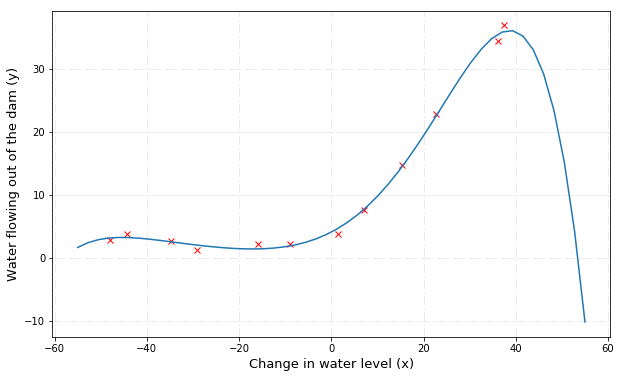

In [50]:
plotFit(fitted_theta,mu,sigma)

In [133]:
def plotPolyLearningCurve(lam=0):
    yshape,error_train,error_val=[],[],[]
    initial_theta=np.ones((7,1))
    Xval1,d1,d2=featureNormalize(polyFeatures(Xval,6))
    Xval1=np.insert(Xval1,0,1,axis=1)
    for i in range(1,13):
        Xsample=X[:i,:]
        ysample=y[:i]
        yshape.append(ysample.shape[0])
        XX,d1,d2=featureNormalize(polyFeatures(Xsample,6))            
        XX=np.insert(XX,0,1,axis=1)
        fitted_theta=optimization(initial_theta,XX,ysample,lam,print_output=False).reshape((7,1))
        error_train.append(costfunc(fitted_theta,XX,ysample,lam=0))      # Be cautious that there won't be regularized term in Jrain and Jcv
        error_val.append(costfunc(fitted_theta,Xval1,yval,lam=0))       # Be cautious that there won't be regularized term in Jrain and Jcv
    plt.figure(figsize=(10,6))
    plt.plot(yshape,error_train,label='error_train')
    plt.plot(yshape,error_val,label='error_val')
    plt.legend()
    plt.grid(linestyle='-.',alpha=0.3)
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Error')
    plt.title('Polynomial Regression Learning Curve (lambda=%s)' % lam)

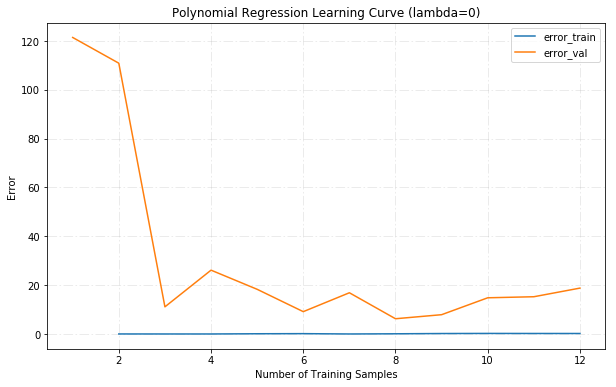

In [134]:
plotPolyLearningCurve()

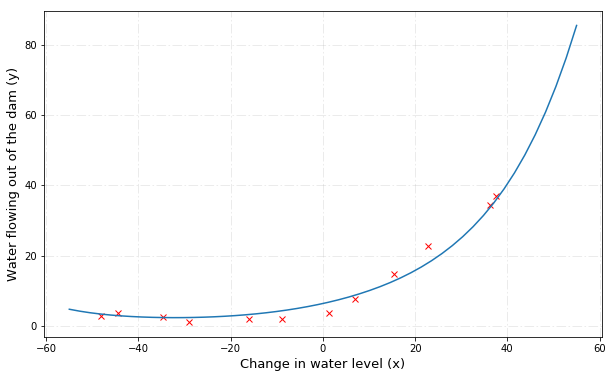

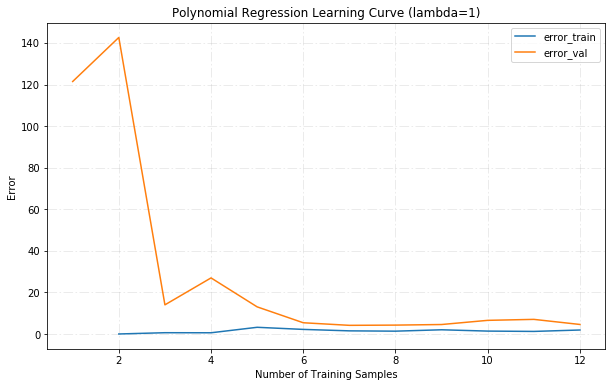

In [135]:
# lambda=1
fitted_theta1=optimize1(start_theta,X_poly,y,lam=1).x.reshape((7,1))
plotFit(fitted_theta1,mu,sigma)
plotPolyLearningCurve(lam=1)

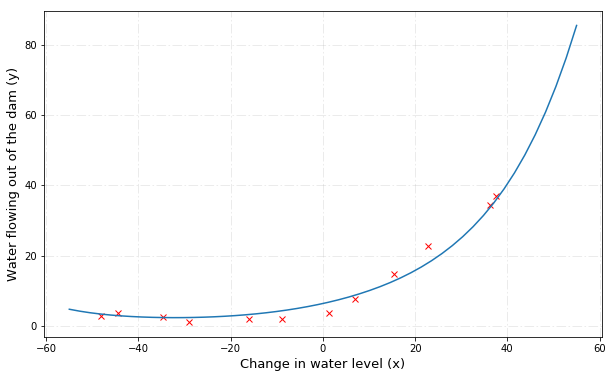

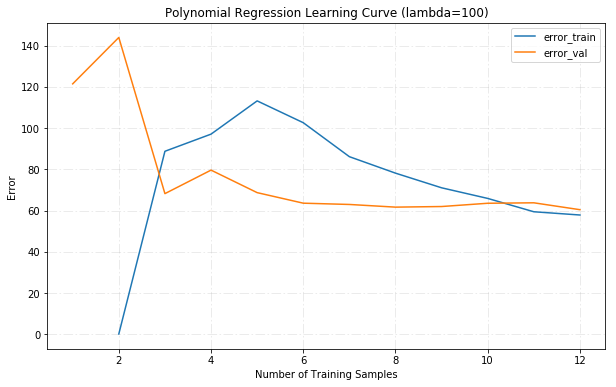

In [136]:
# lambda=100
fitted_theta2=optimize1(start_theta,X_poly,y,lam=100).x.reshape((7,1))
plotFit(fitted_theta1,mu,sigma)
plotPolyLearningCurve(lam=100)

## 2.3 Selecting lambda using cross validation set

In [149]:
def valigationCurve():
    lamrange=np.linspace(0,10,50)
    lamsize,error_train,error_val=[],[],[]
    Xval1,d1,d2=featureNormalize(polyFeatures(Xval,6))
    Xval1=np.insert(Xval1,0,1,axis=1)
    X1,d1,d2=featureNormalize(polyFeatures(X,6))
    X1=np.insert(X1,0,1,axis=1)
    start_theta=np.ones((7,1))
    for lam in lamrange:
        lamsize.append(lam)
        fit_theta=optimization(start_theta,X1,y,lam,print_output=False).reshape((7,1))
        error_train.append(costfunc(fit_theta,X1,y,lam=0))        # Be cautious that there won't be regularized term in Jrain and Jcv
        error_val.append(costfunc(fit_theta,Xval1,yval,lam=0))          # Be cautious that there won't be regularized term in Jrain and Jcv
    print('Best lambda value: %.1f' % lamrange[np.argmin(error_val)])
    plt.figure(figsize=(10,6))
    plt.plot(lamsize,error_train,label='Train')
    plt.plot(lamsize,error_val,label='Validation')
    plt.legend()
    plt.xlabel('Lambda')
    plt.ylabel('Error')

Best lambda value: 1.2


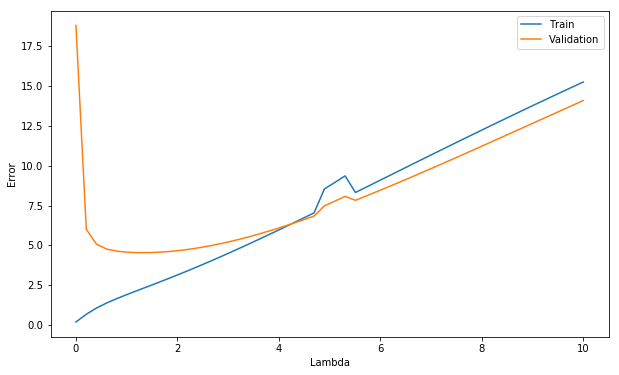

In [150]:
valigationCurve()

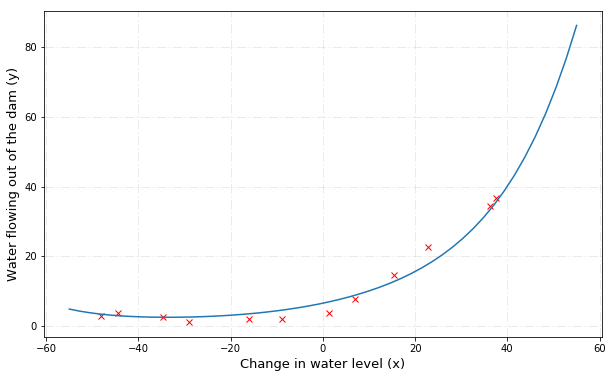

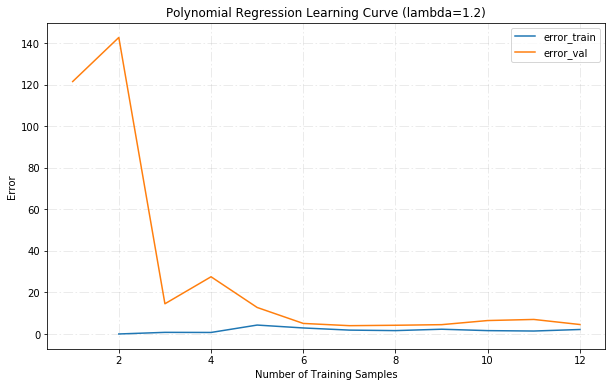

In [155]:
# lambda=1.2
fitted_theta3=optimization(start_theta,X_poly,y,lam=1.2,print_output=False).reshape((7,1))
plotFit(fitted_theta3,mu,sigma)
plotPolyLearningCurve(lam=1.2)

In [156]:
# test error
Xt,d1,d2=featureNormalize(polyFeatures(Xtest,6))
Xt=np.insert(Xt,0,1,axis=1)
costfunc(fitted_theta3,Xt,ytest,lam=0)           # Be cautious that there won't be regularized term in Jtest

7.2356036644116575